# AMNH CG2 | Class 09 - Annotations | Part 1: Parsing `GFF` files
**Víctor Sojo** | `vsojo@amnh.org`<br/>

Genomes have multiple features within them. Information about these features, such as the location and given names of genes, mRNAs, coding sequences (CDSs), exons, and more, are typically given in **Generic Feature Format (`GFF`)** files.

Here we will parse a `GFF` file containing annotations for the genome of a _Saccharomyces cerevisiae_ strain, as published online by the Yeast Genome consortium.

**References**: Some elements of this lesson are based on chapter 3 from Tiago Antao's [_Bioinformatics with Python Cookbook_](https://www.amazon.com/dp/1789344697/), 2nd Ed. (Packt, 2018), and some others on the [BioPython tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html). [This tutorial](https://www.biostars.org/p/57549/) was also very useful, as was the general [BioPython reference](https://biopython.org/).

## Before we start – Make sure you're using the right `conda` environment
If you're following along the instructions that you must have received separately in a PDF document, you should be here under your `cg2` environment. You can confirm that with:

In [1]:
!echo $CONDA_DEFAULT_ENV

cg2


If you see anything other than `cg2` being printed out, please go back to the PDF and make sure you followed it correctly. You'll have to close this window and then "**Quit**" in the main Jupyter window (if you still have it open, no worries if not). Then make sure you do:<br/>
`jupyter notebook stop`<br/>
`conda activate cg2`<br/>
`jupyter notebook`<br/>

If that still fails, please [send me an email](mailto:vsojo@amnh.org).

## Import libraries & packages
We will need the following:

|Library/Package | Purpose |
|:---------------|:--------|
|`gffutils`      | Allows us to create a database, to be mined |
|`reportlab`     | To graph genomes at the end of this notebook|
|`GenomeDiagram` | As above|
|`Bio.SeqIO`     | To process sequences using Biopython|
|`Image`         | Let's us put images on the notebook|

<br/>
Again, please make sure you followed the instructions in the PDF closely, where the relevant packages were installed.<br/>
Then you can execute the following code by clicking in the cell (i.e. block of text) that contains the code and hitting the play (Run) button above, or hitting Shift+Return on your keyboard.

In [2]:
import gffutils
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Graphics import GenomeDiagram
from IPython.display import Image

The above is **Python** code. Most things in a Jupyter Notebook cell are either [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) – such as the text in this cell — or  Python code. However, you can specify other languages too, as we will see in the next cell.

## Download the `GFF` file
We will download the `GFF` file for the genome of **_S. cerevisiae_**. We will download this from the Yeast Genome consortium.

**Technical note:** Whether you use `wget` or `curl -O` for this will depend on whether you're on Linux or Mac OS, so uncomment the appropriate line below by removing the `#` but not the `!`.

This below is one of the many wonders of Jupyter Notebooks: you can run Unix code inside them just as you can run Python code; all you have to do is precede the `bash` code with a `!`.

In [3]:
# If you're on Linux, uncomment the following line and leave everything else in this cell commented
#!wget http://sgd-archive.yeastgenome.org/curation/chromosomal_feature/saccharomyces_cerevisiae.gff.gz

# If you're on a Mac, uncomment the following and leave everything else in this cell commented
!curl -O http://sgd-archive.yeastgenome.org/curation/chromosomal_feature/saccharomyces_cerevisiae.gff.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4758k  100 4758k    0     0  2875k      0  0:00:01  0:00:01 --:--:-- 2873k


The file should be downloaded now. We can confirm this by doing `ls -l` and checking that it's really there:

In [4]:
!ls -lh

total 11296
-rwxr-xr-x@ 1 sojovictor  staff   408K Nov 17 22:35 CG2_Class09_part1_GFFs.ipynb
-rw-r--r--@ 1 sojovictor  staff   112K Nov 18 09:56 CG2_Class09_part2_BLAST.ipynb
-rw-r--r--@ 1 sojovictor  staff   125K Nov 17 22:57 blast_test_just_in_case_ncbi_is_too_slow.xml
-rw-r--r--@ 1 sojovictor  staff   4.6M Nov 18 10:21 saccharomyces_cerevisiae.gff.gz


You should see a file called `saccharomyces_cerevisiae.gff.gz` that weighs around `4.6MB`.<br/>
Let's take a look at it, but first we'll need to decompress it. We could use the `!` opener again, but we can actually declare an entire cell as being `bash` code by using the `%%bash` Jupyter "magic".

In [5]:
%%bash
# decompress the file
gunzip -f saccharomyces_cerevisiae.gff.gz

# Print some information about it:
echo "The file has `cat saccharomyces_cerevisiae.gff | wc -l` lines"
echo "The contents of the file start like this:"

# take a look at its first lines
head -30 saccharomyces_cerevisiae.gff

The file has   175844 lines
The contents of the file start like this:
##gff-version 3
#!date-produced 2020-11-11 17:29:02
#!data-source SGD
#!assembly R64-2-1
#
# Saccharomyces cerevisiae S288C genome (version=R64-2-1)
#
# Features from the 16 nuclear chromosomes labeled chrI to chrXVI,
# plus the mitochondrial genome labeled chrmt.
#
# Created by Saccharomyces Genome Database (http://www.yeastgenome.org/)
#
# Weekly updates of this file are available for download from:
# https://downloads.yeastgenome.org/latest/saccharomyces_cerevisiae.gff.gz
#
# Please send comments and suggestions to sgd-helpdesk@lists.stanford.edu
#
# SGD is funded as a National Human Genome Research Institute Biomedical Informatics Resource from
# the U. S. National Institutes of Health to Stanford University.
#
chrI	SGD	chromosome	1	230218	.	.	.	ID=chrI;dbxref=NCBI:BK006935.2;Name=chrI
chrI	SGD	telomere	1	801	.	-	.	ID=TEL01L;Name=TEL01L;Note=Telomeric%20region%20on%20the%20left%20arm%20of%20Chromosome%20I%3B%20co

It's always a good idea to explore the entire file if the size allows, but for now let's just take a look at the end.

In [6]:
!tail saccharomyces_cerevisiae.gff

ATGATGTAATTGGTTAACATTTTAGGGTCATGACCTAATTATATACGTTCAAATCGTATTATTGCTAATAAATTAATATA
TAATATTTATAAAAAAGTATAATAAAATATATTATAAGAAGAATATATTATATAATAATTATATTAATAATATTAATAAA
TAATATATAAATAATTATAAAAAAGTATATAATATTAATCAATTAATTAATTAATAAATATAAATAATATATTAATTTTT
AATTAATTTGAATAAGATATTTATATTATTAATAGGAAAGTCATAAATATATAAATTATATTATATAATTAATATAATAA
TAAAATAAATTATATATTTTATTTATAATATTATTTCTTTATAAGATAAAATATTATCTGATGAATAATTAGATTGAATA
ATATTTATAAAGAAATATATATAAAAAGTCATTATATAAATTTAATTATAATTTAAATAAATTTTATATAAATTAATATA
ATATTAATAAAGTAATTAGTATAAATAAATAATATGAAAATAAAACTTAATAAATATATAAATATAGTCCGGCCCGCCCC
CCCGCGGCGGGCGGACCCCGAAGGAGTGAGGGACCCCTCCCTAATGGGAGGGGGACCGAACCCCTTTTTAAGAAGGAGTC
CATATATATATATTAATAAAAAAAAGTAATATATATATATATATTGGAATAGTTATATTATTATACAGAAATATGCTTAA
TTATAATATAATATCCATA


This `GFF` file contains a long list of _features_ in the genome of our organism, including what type of feature it is (the 3rd column), which "contig" contains the feature (1st column), where in that contig the feature can be found (4th, 5th and 7th columns), and some hopefully unique information about the feature, such as its ID (last column).

Then, towards the end, it has DNA sequences, which predictably correspond to the contigs (in this case the contigs are the chromosomes, but this will depend on your assembly and type of organism). We can confirm this by trying to find the line that contains the contig for chromosome 1 (plus a couple of lines after it by using `-A2`), which in this annotation is called `chrI`:

In [7]:
!grep -A2 ">chrI" saccharomyces_cerevisiae.gff

>chrI
CCACACCACACCCACACACCCACACACCACACCACACACCACACCACACCCACACACACACATCCTAACACTACCCTAAC
ACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCAT
--
>chrII
AAATAGCCCTCATGTACGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACCTTTA
TTTTATGTTTACTTTTTATAGGTTGTCTTTTTATCCCACTTCTTCGCACTTGTCTCTCGCTACTGCCGTGCAACAAACAC
--
>chrIII
CCCACACACCACACCCACACCACACCCACACACCACACACACCACACCCACACACCCACACCACACCACACCCACACCAC
ACCCACACACCCACACCCACACACCACACCCACACACACCACACCCACACACACCCACACCCACACACCACACCCACACA
--
>chrIV
ACACCACACCCACACCACACCCACACACACCACACCCACACACCACACCCACACCCACACACCCACACCCACACACCACA
CACCACACCACACCACACCCACACCCACACCACACCCACACCCACACACCACACCCACACCCACACACCACACACTACCC
--
>chrIX
CACACACACCACACCCACACCACACCACACCACACCCACACCCACACACACCACACCCACACACCACACCCACACCAACT
CTCTCTCATCTACCTTTACTCGCGCTGTCACACCTTACCCGGCTTTCTGACCGAAATTAAAAAAAATGAAAATGAAATCC


OK, that didn't quite work as expected, but it's fine, we got the information we needed.<br/>
(if you want to know the appropriate RegEx, you should do something like `">chrI$"`, which would target only the first chromosome by using the `$` to indicate that the line must end after the `I`)

Let's count the number of **gene**s in the _S. cerevisiae_ genome using `grep`:

In [8]:
!grep -c "\tSGD\tgene\t" saccharomyces_cerevisiae.gff

6600


...and how many **CDS**s (**C**o**D**ing **S**equences)?

In [9]:
!grep -c "\tSGD\tCDS\t" saccharomyces_cerevisiae.gff

7058


## Creating a `gffutils` database for efficient parsing of the GFF file

Let's create a database (we first remove it if it's already there, so that we're sure we're starting afresh) using `gffutils`:

In [10]:
![ -f Scerev_gff.db ] && rm -f Scerev_gff.db # Delete the database if it's already there
db = gffutils.create_db('saccharomyces_cerevisiae.gff', 'Scerev_gff.db')

Note that in the cell above we are combining `bash` code (first line) with `python` code (second line, without the `!`). Cool, innit?

## Parsing the `gffutils` database

### Counting the numbers of features of each kind

Now that we have a `gffutils` database, we can do far more interesting parsing than with `grep`.<br/>
For example, instead of counting each feature one by one, let's count the numbers of all the features in the GFF file:

In [11]:
for feat_type in db.featuretypes():
  print(feat_type, db.count_features_of_type(feat_type))
  # Python can print really nicely formatted text, so try commenting the line above and uncommenting the next one
  #print(f"{feat_type:>35} : {db.count_features_of_type(feat_type):>4}")

ARS 543
ARS_consensus_sequence 196
CDS 7058
LTR_retrotransposon 50
W_region 2
X_element 32
X_element_combinatorial_repeat 28
X_region 3
Y_prime_element 19
Y_region 3
Z1_region 3
Z2_region 2
blocked_reading_frame 12
centromere 32
centromere_DNA_Element_I 16
centromere_DNA_Element_II 16
centromere_DNA_Element_III 16
chromosome 17
external_transcribed_spacer_region 8
five_prime_UTR_intron 24
gene 6600
intein_encoding_region 2
internal_transcribed_spacer_region 8
intron 377
long_terminal_repeat 383
mRNA 6600
mating_type_region 2
matrix_attachment_site 8
ncRNA 18
ncRNA_gene 18
noncoding_exon 484
origin_of_replication 8
plus_1_translational_frameshift 47
pseudogene 12
rRNA 24
rRNA_gene 27
region 78
silent_mating_type_cassette_array 4
snRNA 6
snRNA_gene 6
snoRNA 77
snoRNA_gene 77
tRNA 299
tRNA_gene 299
telomerase_RNA 1
telomerase_RNA_gene 1
telomere 64
telomeric_repeat 31
transposable_element 91
transposable_element_gene 91
uORF 9


### Printing all features of the same kind
From the list above, it would seem _S. cerevisiae_ has 17 chromosomes.<br/>
Just to be safe, let's take a look [on Wikipedia](https://en.wikipedia.org/wiki/Saccharomyces_cerevisiae#Genome_sequencing). Here's what I found:
> The _S. cerevisiae_ genome is composed of about 12,156,677 base pairs and 6,275 genes, compactly organized on **16 chromosomes**.

Hm... what's going on here?
Let's print out all of those chromosomes, and their start and end positions (i.e. their lengths)

In [12]:
for chrom in db.features_of_type('chromosome'):
  print(chrom.seqid, chrom.start, chrom.end, sep="\t")

chrI	1	230218
chrII	1	813184
chrIII	1	316620
chrIV	1	1531933
chrV	1	576874
chrVI	1	270161
chrVII	1	1090940
chrVIII	1	562643
chrIX	1	439888
chrX	1	745751
chrXI	1	666816
chrXII	1	1078177
chrXIII	1	924431
chrXIV	1	784333
chrXV	1	1091291
chrXVI	1	948066
chrmt	1	85779


...ah... mitochondria, nobody remembers poor mitochondria... but try breathing without them!<br/>
Actually, budding yeasts (most strains anyway) can grow anaerobically – which however does not mean they're not using their mitochondria!

### Finding gene counts for each chromosome
We will go over each chromosome and count its number of genes.<br/>
Note that `gffutils` keeps track of which gene belongs to which chromosome, which mRNA belongs to which gene, and so on, so there's a lot we can mine from the database. We will barely scratch the surface here.

In [13]:
for chrom in db.features_of_type('chromosome'):
  cnt = 0
  for gene in db.region((chrom.seqid, chrom.start, chrom.end), featuretype='gene'):
    cnt += 1
  print(f"Chromosome {chrom.seqid:^10} has {cnt:>4} genes")

Chromosome    chrI    has  117 genes
Chromosome   chrII    has  456 genes
Chromosome   chrIII   has  184 genes
Chromosome   chrIV    has  836 genes
Chromosome    chrV    has  323 genes
Chromosome   chrVI    has  139 genes
Chromosome   chrVII   has  583 genes
Chromosome  chrVIII   has  321 genes
Chromosome   chrIX    has  241 genes
Chromosome    chrX    has  398 genes
Chromosome   chrXI    has  348 genes
Chromosome   chrXII   has  578 genes
Chromosome  chrXIII   has  505 genes
Chromosome   chrXIV   has  435 genes
Chromosome   chrXV    has  597 genes
Chromosome   chrXVI   has  511 genes
Chromosome   chrmt    has   28 genes


## Printing all gene features in a chromosome
The mitochondrial genome has only 28 genes, let's print them all out:

In [14]:
for i, gene in enumerate(db.region(seqid='chrmt', featuretype='gene')):
  print(i+1,'\n', gene, '\n\n')

1 
 chrmt	SGD	gene	3952	4338	.	+	.	ID=Q0010;Name=Q0010;Alias=ORF6;Ontology_term=GO:0003674,GO:0008150,SO:0000704;Note=Dubious open reading frame%3B unlikely to encode a protein%2C based on available experimental and comparative sequence data%3B partially overlaps the dubious ORF Q0017;display=Dubious open reading frame;dbxref=SGD:S000007257;orf_classification=Dubious;curie=SGD:S000007257 


2 
 chrmt	SGD	gene	4254	4415	.	+	.	ID=Q0017;Name=Q0017;Alias=ORF7;Ontology_term=GO:0003674,GO:0005575,GO:0008150,SO:0000704;Note=Dubious open reading frame%3B unlikely to encode a protein%2C based on available experimental and comparative sequence data%3B partially overlaps the dubious ORF Q0010;display=Dubious open reading frame;dbxref=SGD:S000007258;orf_classification=Dubious;curie=SGD:S000007258 


3 
 chrmt	SGD	gene	11667	11957	.	+	.	ID=Q0032;Name=Q0032;Alias=ORF8;Ontology_term=GO:0003674,GO:0008150,SO:0000704;Note=Dubious open reading frame%3B unlikely to encode a functional protein%2C based on

Great. We have the information for all genes in the mitochondrial genome of _S. cerevisiae_. We haven't looked at the sequences themselves yet; let's do that next.

## Creating a BioPython record to contain sequences
We have **features** that we extracted from the GFF, such as gene positions within the genome, and descriptions for those features. However, we haven't used the actual sequences to which these features correspond.

As we saw above, the sequences are elsewhere in the same GFF file, in FASTA format. Let's extract them using BioPython.

To keep things simple and quick, we will work only with one of the chromosomes.

So, for all chromosomes, let's print the first `30` bases of their sequence, and **only for one of the chromosomes** let's extract its sequence and create a BioPython record with it.

In [15]:
seqrec = None
desired_chrom = 'chrI' # You could of course change this to any other contig (chromosome) in the genome

for record in SeqIO.parse('saccharomyces_cerevisiae.gff', 'fasta'):
  print(record.id)
  print(record.seq[:30], '...')
  if record.id==desired_chrom:
    seqrec = SeqRecord(
      record.seq
     ,id = 'Sc_'+desired_chrom
     ,annotations = {
        'molecule_type': 'DNA'
       ,'source'       : "Downloaded from the Yeast Genome Database"
     }
    )

chrI
CCACACCACACCCACACACCCACACACCAC ...
chrII
AAATAGCCCTCATGTACGTCTCCTCCAAGC ...
chrIII
CCCACACACCACACCCACACCACACCCACA ...
chrIV
ACACCACACCCACACCACACCCACACACAC ...
chrV
CGTCTCCTCCAAGCCCTGTTGTCTCTTACC ...
chrVI
GATCTCGCAAGTGCATTCCTAGACTTAATT ...
chrVII
CCACACCCACACACACCACACCCACACCCA ...
chrVIII
CCCACACACACCACACCCACACACCACACC ...
chrIX
CACACACACCACACCCACACCACACCACAC ...
chrX
CCCACACACACACCACACCCACACCCACAC ...
chrXI
CACCACACCCACACACCACACCCACACACA ...
chrXII
CACACACACACACCACCCACACACCACACC ...
chrXIII
CCACACACACACCACACCCACACCACACCC ...
chrXIV
CCGGCTTTCTGACCGAAATTAAAAAAAAAA ...
chrXV
ACACCACACCCACACCACACCCACACCCAC ...
chrXVI
AAATAGCCCTCATGTACGTCTCCTCCAAGC ...
chrmt
TTCATAATTAATTTTTTATATATATATTAT ...


Let's take a look at the record we just made for the chosen chromosome:

In [16]:
print(seqrec)

ID: Sc_chrI
Name: <unknown name>
Description: <unknown description>
Number of features: 0
/molecule_type=DNA
/source=Downloaded from the Yeast Genome Database
Seq('CCACACCACACCCACACACCCACACACCACACCACACACCACACCACACCCACA...GGG')


This record contains the sequence of the entire mitodhondrial chromosome, and no other information beyond the name. Let's add a little more information:

In [17]:
seqrec.name        = "S.cerev.R64." + desired_chrom
seqrec.description = "S. cerevisiae R64 chromosome " + desired_chrom + ", extracted from GFF downloaded from the YeastGenomeDatabase"

Let's take another look at the record with this new information:

In [18]:
print(seqrec)

ID: Sc_chrI
Name: S.cerev.R64.chrI
Description: S. cerevisiae R64 chromosome chrI, extracted from GFF downloaded from the YeastGenomeDatabase
Number of features: 0
/molecule_type=DNA
/source=Downloaded from the Yeast Genome Database
Seq('CCACACCACACCCACACACCCACACACCACACCACACACCACACCACACCCACA...GGG')


## Adding features to the BioPython `SeqRecord`
You will notice that the `SeqRecord` we just created for the chosen chromosome doesn't contain any `features`; it's pretty much just a sequence for now.

We will add some of those features that we got from the GFF. But, to simulate a slightly more real-world-like scenario, we will do something a little strange: we will extract from the GFF **only** the information about the **positions** of the genes, nothing else.

That is: we are losing all the information about which genes do what, which we had in the original GFF file. This is of course very silly, you wouldn't normally throw away such valuable information. We're only doing it in this example just so that we can then have a starting point in the next lesson.

This looks a little more like the kind of data you would have in your research: you'd have genome sequences, and you may perhaps have some predictions for gene positions, but you wouldn't know _a priori_ what those genes do. We'll try to look into that in the next lesson, and that's why we're getting rid of all the information here.

Let's add the "features" of type `gene` to the BioPython `SeqRecord` for the chosen chromosome of _S. cerevisiae_.

In [19]:
desired_feature = 'gene'  #  you could try e.g. 'tRNA' or 'ORF' instead of 'gene'
# we still have desired_chrom defined from above, we'll reuse it here to pick the seqid

for i, feature in enumerate(db.region(seqid=desired_chrom, featuretype=desired_feature)): 
  # Extract the id of this feature from its attributes (i.e. the last column)
  feature_id     = feature.attributes['ID'][0]
  # actually, we won't use that ID for anything here. Typically we would, but our idea here is
  # to get rid of everything other than the positions and strand.
  
  # Process the strand (positive, negative, or unknown?)
  feature_strand = 0 # Start it at zero just in case the strand is undefined in the GFF
  if feature.strand in ['-', '+']:
    feature_strand = int(feature.strand+"1") # FeatureLocation wants either 0, -1, or +1
  
  # Create the FeatureLocation for this feature
  feature_loc    = FeatureLocation(feature.start, feature.end, strand=feature_strand)
  #print(f"Adding features for {desired_feature}", feature_id, "located at", feature_loc)
  
  # Create a new Sequence Feature with this information, 
  seqfeat = SeqFeature(
     feature_loc
    ,type=desired_feature
    ,qualifiers = {
        'locus_tag' : f'{seqrec.id}_{i+1:02}'
      }
  )
  seqfeat.id = f'{seqrec.id}_{i+1:02}'
  
  # and append it to the sequence record that we built from the downloaded genome
  seqrec.features.append(seqfeat)

Great! Now we have a sequence record that has both the sequence as such, and where genes (or whatever feature you chose above) are on that sequence.

You will notice that we have just wasted a lot of very useful information, such as the gene ID (which we replaced for an almost meaningless one), what it is predicted to do, and so on.

However, this that we're ending up looks a lot more like the kind of data that you would get in a real project: i.e. you'd have genome sequences, and you may perhaps have some gene predictions, but you wouldn't know a priori what those genes do. We'll try to look into that in another lesson.

## Export all query sequences to FASTA format
Let's export all the sequences each to its own FASTA file.

While we're at it, let's also make a list to contain the gene IDs, so that we can use them later.

In [20]:
!mkdir fasta
gene_id_list = []
for feature in seqrec.features:
  gene_record = SeqRecord(
     feature.extract(seqrec.seq)      # extract the sequence corresponding to this feature
    ,id=feature.qualifiers['locus_tag']   # the id for this record
    ,name=feature.qualifiers['locus_tag'] # the name (we'll just use the id again)
    ,description="<unknown>"                       # we have no idea what this gene does
  )
  
  gene_id_list.append(gene_record.id)
  print(gene_record.id)
  # Make a FASTA file for this gene
  fasta_file = 'fasta/' + gene_record.id + '.fasta'
  with open(fasta_file, 'w') as f:
    f.write(gene_record.format("fasta"))

Sc_chrI_01
Sc_chrI_02
Sc_chrI_03
Sc_chrI_04
Sc_chrI_05
Sc_chrI_06
Sc_chrI_07
Sc_chrI_08
Sc_chrI_09
Sc_chrI_10
Sc_chrI_11
Sc_chrI_12
Sc_chrI_13
Sc_chrI_14
Sc_chrI_15
Sc_chrI_16
Sc_chrI_17
Sc_chrI_18
Sc_chrI_19
Sc_chrI_20
Sc_chrI_21
Sc_chrI_22
Sc_chrI_23
Sc_chrI_24
Sc_chrI_25
Sc_chrI_26
Sc_chrI_27
Sc_chrI_28
Sc_chrI_29
Sc_chrI_30
Sc_chrI_31
Sc_chrI_32
Sc_chrI_33
Sc_chrI_34
Sc_chrI_35
Sc_chrI_36
Sc_chrI_37
Sc_chrI_38
Sc_chrI_39
Sc_chrI_40
Sc_chrI_41
Sc_chrI_42
Sc_chrI_43
Sc_chrI_44
Sc_chrI_45
Sc_chrI_46
Sc_chrI_47
Sc_chrI_48
Sc_chrI_49
Sc_chrI_50
Sc_chrI_51
Sc_chrI_52
Sc_chrI_53
Sc_chrI_54
Sc_chrI_55
Sc_chrI_56
Sc_chrI_57
Sc_chrI_58
Sc_chrI_59
Sc_chrI_60
Sc_chrI_61
Sc_chrI_62
Sc_chrI_63
Sc_chrI_64
Sc_chrI_65
Sc_chrI_66
Sc_chrI_67
Sc_chrI_68
Sc_chrI_69
Sc_chrI_70
Sc_chrI_71
Sc_chrI_72
Sc_chrI_73
Sc_chrI_74
Sc_chrI_75
Sc_chrI_76
Sc_chrI_77
Sc_chrI_78
Sc_chrI_79
Sc_chrI_80
Sc_chrI_81
Sc_chrI_82
Sc_chrI_83
Sc_chrI_84
Sc_chrI_85
Sc_chrI_86
Sc_chrI_87
Sc_chrI_88
Sc_chrI_89
Sc_chrI_90
Sc_chrI_91

Write those gene IDs to a file, so that we can use them later

In [21]:
with open('gene_IDs.list', 'w') as f:
  for id in gene_id_list:
    f.write(id + '\n')

## Exporting the sequence with features (e.g. gene positions) as a GenBank file
Let's export this new record to a GenBank file, which, similar to a GFF, includes both gene positions and the full sequence.

Why, you may ask, are we exporting as a GenBank file instead of GFF? Well, just so you witness a major bane of bioinformatics: many many types of files that do partly the same, but not quite.

But before we export the file, let's add a bit more information to the record, such as the organism, and where we got the data.

In your real-world case, you would probably add where you sampled this organism, and any useful information you have about it that you think would be good to have in this file. Don't hold back here, more information is better than less.

In [22]:
seqrec.annotations['organism']   = "Saccharomyces cerevisiae R64-1-1 Chromosome " + desired_chrom + " DNA"
seqrec.annotations['source']     = "YeastGenomeDatabase GFF"

Now we can export the file to the `genbank` format.

In [23]:
SeqIO.write(seqrec, "Saccharomyces_cerevisiae.R64-1-1.dna."+desired_chrom+".gb", "genbank")

1

## Visualising (a tiny bit of) the genome
We now have a sequence record, which we exported to `genbank` format. This record is still in memory, so we can keep using it for other purposes. For example, Let's plot the genome of the chosen chromosome of _S. cerevisiae_.

First, we declare the `GenomeDiagram` objects that will hold our genome for plotting.

In [24]:
gd_diagram = GenomeDiagram.Diagram("S_cerevisiae | " + desired_chrom + " DNA")
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Genes")
gd_feature_set = gd_track_for_features.new_set()

Next we add each of the genes to the graph, in their appropriate locations.

We alternate colours for even and odd genes, just so that we can see them when they overlap.

In [25]:
for i, feature in enumerate(seqrec.features):
  # Process only the desired feature type
  if feature.type == desired_feature:
    # Choose a different colour for even and odd genes
    if i % 2 == 0:
      color = 'cornflowerblue'
    else:
      color = 'peachpuff'
    gd_feature_set.add_feature(feature, color=color, label=True, label_size=16, name=feature.id)

And finally, make the plot, using the circular mode.

In [26]:
gd_diagram.draw(
  format='circular',
  circular=True,
  #pagesize=(600, 600),
  start=0,
  end=len(seqrec),
  circle_core=0.85,
)
#gd_diagram.write('S_cerevisiae_'+desired_chrom+'.pdf', 'PDF')
#gd_diagram.write('S_cerevisiae_'+desired_chrom+'.eps', 'EPS')
#gd_diagram.write('S_cerevisiae_'+desired_chrom+'.svg', 'SVG')
gd_diagram.write('S_cerevisiae_'+desired_chrom+'.png', 'PNG')

Here's the image we just created:

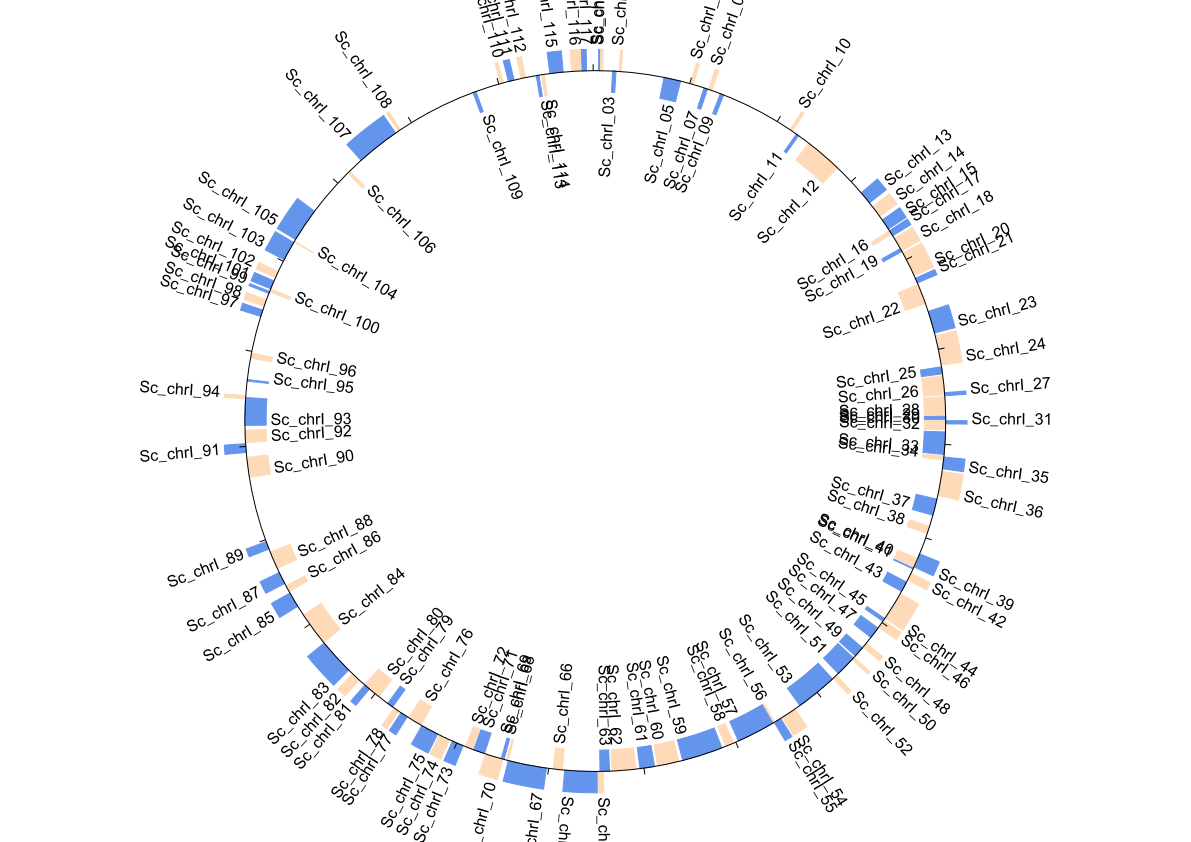

In [27]:
Image('S_cerevisiae_'+desired_chrom+'.png')

**Warning!**<br/>

We're plotting the chromosome as circular. This looks very pretty, but... is it true? Maybe for the mitochondrial chromosome (`chrmt`) it would have been, but for the others?

Like with everything in bioinformatics, you need to be sure that what you're doing makes sense. The computer knows no biology.

On that note, no part of this lesson is meant for biological correctness. There may be plenty of errors (biological or otherwise) in the assumptions above. The intention here was only to demonstrate some of the bioinformatics principles.